# Multi-task (=multi-output) Bayesian Optimization with GPy and GPyOpt

In this notebook I demonstrate how to frame the multi-task global optimization using GPyOpt.

It includes:
 - fitting of individual GPs 
 - fitting of multi-task GPs using coregionalization
 - BO optimization of single function
 - BO optimization of 2-task problem
 - An implementation of a custom acquisition function
 - Extensive visualization of the optimization process

What's still missing is an implementation of EntropySearch acquisition (for example like the one in https://github.com/automl/RoBO) and a strategy for choosing the final decision (optimal point) based on the tasks fits / samples from the tasks (for example: choose the point in the middle between the best points found for all the tasks).

## Problem setting

**Let's say that we have two functions (tasks). Function no 0 is expensive to evaluate, whereas function no 1 is relatively cheap to evaluate. The functions may have different scales and biases, however, we assume that functions are related, e.g., have similar curvature. Our objective is to find minimum of function no 0.**

## Agenda

 1) First, I demonstrate fitting functions with GP-regression independently and then using multi-task (coregionalized) kernel.

 2) Then, I show how Bayesian Optimization (BO) can be used to find the minimum of function no 0.

 3) Finally, by using multi-task kernel with BO and cost function, I present how to optimize function no 0 while relying mostly on evaluating function no 1.

## Helpful Links

https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb - List of GPyOpt notebooks

https://papers.nips.cc/paper/5086-multi-task-bayesian-optimization.pdf - *Multi-Task Bayesian Optimization* publication.

## Imports

In [1]:
!pip install emcee GPy GPyOpt numpy matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt

In [3]:
import pylab as pl
from IPython import display
import time

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

## Auxiliary plotting

In [5]:
def plot_err(x, y, yerr, color=None, alpha_fill=0.2, ax=None, label="", lw=1, ls="-"):
    y, yerr = y.reshape(-1), yerr.reshape(-1)    
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label, lw=lw, ls=ls)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidth=0.0)

## Problem specification: true functions (tasks) that have different scales and biases but similar curvature

In [6]:
f0 = lambda X: np.sin(6*X)*1.5-0.5
f1 = lambda X: np.sin(6*X+0.5)*0.5+1.5

In [7]:
plt_X = np.arange(-0.5, 1.55, 0.05)

This is how the functions we want to optimize look like (in reality they are usually multi-dimensional and impossible to plot)

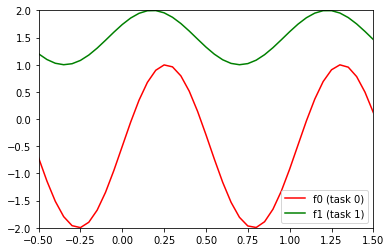

In [8]:
plt.plot(plt_X, f0(plt_X), color="red", label="f0 (task 0)")
plt.plot(plt_X, f1(plt_X), color="green", label="f1 (task 1)")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend();

## Functions' noisy samples: only few from f0 but many from f1

In the process of optimization, more and more samples from the functions will be obtained and used for fitting a GP. We can simulate one step by obtaining some samples (here random, but in reality determined by an acquisition function) and observing how the fits would look like.

In [9]:
# Noisy evaluation
evaluate_f0 = lambda X0: f0(X0) + np.random.standard_t(3, X0.shape)*0.005
evaluate_f1 = lambda X1: f1(X1) + np.random.standard_t(3, X1.shape)*0.0005

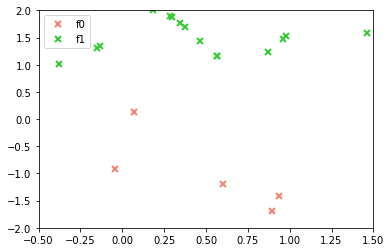

In [10]:
np.random.seed(123)
X0 = np.random.rand(5, 1)*2 -0.5
X1 = np.random.rand(15, 1)*2 -0.5 
Y0 = evaluate_f0(X0)
Y1 = evaluate_f1(X1)

plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="f0")
plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="f1")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend();

## Fitting individual regressions separately (using noisy samples)

Below I just show how GP fit looks like. No optimization done yet.

### Kernel

In [11]:
def get_kernel_basic(input_dim=1):    
    #return GPy.kern.RBF(1, active_dims=[0], lengthscale=1.0, ARD=1) + GPy.kern.Bias(input_dim)
    return GPy.kern.Matern52(input_dim, ARD=1) + GPy.kern.Bias(input_dim) #+ GPy.kern.White(input_dim)     

### Function 0

In [12]:
model = GPy.models.GPRegression(X0, Y0, get_kernel_basic())

In [13]:
print("Model before optimization:")
model

Model before optimization:


GP_regression.,value,constraints,priors
sum.Mat52.variance,1.0,+ve,
sum.Mat52.lengthscale,1.0,+ve,
sum.bias.variance,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


**Note that apart from kernel parameters we have one model parameter (likelihood noise).**

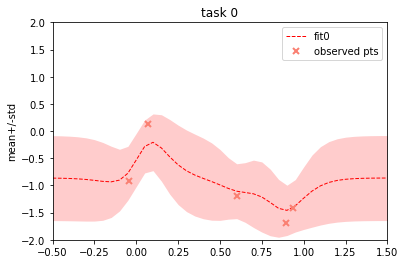

In [14]:
model.optimize()

#model.plot(plot_data=False, plot_inducing=False) # 95%-CI
means0, var = model.predict(np.transpose(plt_X.reshape(1,-1)))
stds0 = np.sqrt(var)
plot_err(plt_X, means0, stds0, lw=1, ls="--", color="red", label="fit0")
plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 0"); plt.ylabel("mean+/-std");

In [15]:
print("Model after optimization:")
model

Model after optimization:


GP_regression.,value,constraints,priors
sum.Mat52.variance,0.34652982900640733,+ve,
sum.Mat52.lengthscale,0.12809015879505556,+ve,
sum.bias.variance,0.9907587219414015,+ve,
Gaussian_noise.variance,0.1437327063859984,+ve,


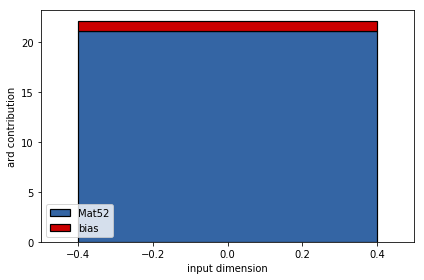

In [16]:
model.kern.plot_ARD(); plt.legend()

### Function 1

In [17]:
model = GPy.models.GPRegression(X1, Y1, get_kernel_basic())
model

GP_regression.,value,constraints,priors
sum.Mat52.variance,1.0,+ve,
sum.Mat52.lengthscale,1.0,+ve,
sum.bias.variance,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


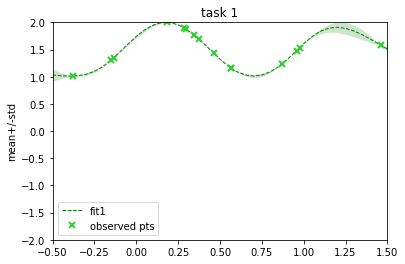

In [18]:
model.optimize()

#model.plot(plot_data=False, plot_inducing=False) # 95%-CI
means1, var = model.predict(np.transpose(plt_X.reshape(1,-1)))
stds1 = np.sqrt(var)
plot_err(plt_X, means1, stds1, lw=1, ls="--", color="green", label="fit1")
plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 1"); plt.ylabel("mean+/-std");

**Since there were many more samples of f1 the fit is way better than for f0**

In [19]:
print("Model after optimization:")
model

Model after optimization:


GP_regression.,value,constraints,priors
sum.Mat52.variance,0.7310449115032169,+ve,
sum.Mat52.lengthscale,0.6227422876166834,+ve,
sum.bias.variance,1.4846928451358454,+ve,
Gaussian_noise.variance,8.595829284653469e-07,+ve,


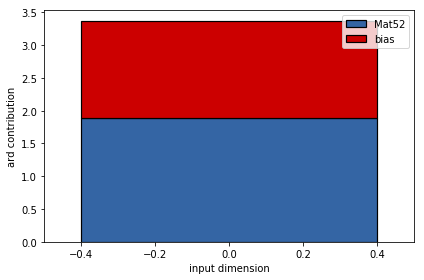

In [20]:
model.kern.plot_ARD(); plt.legend()

## Individual Optimization of only Task 0 

### Auxiliary plotting

In [21]:
def plot_next_acquisitions(bo, DIM_NO=0):
    for x in bo.suggest_next_locations():
        plt.axvline(x=x[DIM_NO], color="salmon", ls="--", lw=2, label="next acquisition")

In [22]:
def normalize(vs):
    return (vs - min(vs))/(max(vs - min(vs)))

def plot_acquisition(bo, DIM_NO=0, grid=0.001):
    bounds = bo.acquisition.space.get_bounds()
    x_grid = np.arange(bounds[DIM_NO][0], bounds[DIM_NO][1], grid)
    x_grid = x_grid.reshape(len(x_grid),1)
    acqu0 = -bo.acquisition.acquisition_function(x_grid)
    #plt.plot(x_grid, normalize(-acqu0), label="task 0", color="red", lw=2)
    plt.plot(x_grid, acqu0, label="task 0", color="red", lw=2)
    
    plot_next_acquisitions(bo, DIM_NO)    
    plt.xlim(-0.6,1.6); plt.legend(loc=2); plt.title("acquisition function"); plt.grid();

In [23]:
def plot_task(bo):
    plt.plot(plt_X, f0(plt_X), color="red", label="f0")
    # note the difference in returned value vs. regression model
    means0mt, stds0mt = bo.model.predict( plt_X.reshape(-1,1) ) 
    plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="BO fit0", alpha_fill=0.2)

    X,Y = bo.get_evaluations()
    plt.scatter(X,Y, color="k", marker="x", label="acquisition pts")
    
    plot_next_acquisitions(bo)
    plt.xlim(-0.6,1.6); plt.ylim(-2,2); plt.legend(loc=2); plt.title("function fit"); plt.grid()

In [24]:
RENAME = {"Gaussian_noise.variance": "noise.var"}

def plot_params(bo):
    plt.xlim(-1,1); plt.ylim(-1,1); plt.axis('off');
    
    for i, (n, v) in enumerate(zip(bo.model.get_model_parameters_names(), bo.model.get_model_parameters()[0])):        
        n = ".".join(n.split(".")[-2:])
        n = RENAME.get(n, n)
        plt.text(-0.9, 0.9-i*0.2, "%s:" % (n), ha="left", va="top", fontsize=13)    
        plt.text(0.5, 0.9-i*0.2, "%.3f" % (v), ha="left", va="top", fontsize=13)    

In [25]:
def plot_bo(bo):  
    plt.figure(figsize=(18,4))
    plt.subplot(1,3,1)
    plot_task(bo); 
    plt.subplot(1,3,2)
    plot_acquisition(bo)
    plt.subplot(1,3,3)
    plot_params(bo)

### Optimization

In [26]:
initial_iter = 3
max_iter  = 10                         
kernel = get_kernel_basic()

bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-0.5,1.5)}]
objective = GPyOpt.core.task.SingleObjective(evaluate_f0)

In [27]:
model = GPyOpt.models.GPModel(optimize_restarts=5, verbose=False, kernel=kernel, exact_feval=False)
space = GPyOpt.Design_space(space=bounds)
acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('random', space, initial_iter)

**acquisition function that decides where to evaluate next**

In [28]:
# MPI
#acquisition = GPyOpt.acquisitions.AcquisitionMPI(model, space, optimizer=acquisition_optimizer)


# LCB
#acquisition = GPyOpt.acquisitions.AcquisitionLCB(model, space, optimizer=acquisition_optimizer)


# EI
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=acquisition_optimizer)

# ES (experimental implementation)
# from GPyOpt.util import mcmc_sampler
# sampler = mcmc_sampler.AffineInvariantEnsembleSampler(space)
# acquisition = GPyOpt.acquisitions.AcquisitionEntropySearch(model, space, 
#                                                            optimizer=acquisition_optimizer, sampler=sampler)


# # # ES (experimental implementation)
# from GPyOpt.util import mcmc_sampler
# ei = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=acquisition_optimizer)
# proposal_function = lambda x : np.clip(np.log(ei._compute_acq(x)), 0., np.PINF)
# sampler = mcmc_sampler.AffineInvariantEnsembleSampler(space)
# acquisition = GPyOpt.acquisitions.AcquisitionEntropySearch(model, space, sampler, 
#                                        optimizer=acquisition_optimizer, 
#                                        num_representer_points=50, 
#                                        burn_in_steps=10, 
#                                        num_samples=100, 
#                                        proposal_function = proposal_function)

In [29]:
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design, 
                                                normalize_Y=False)

**I observed that normalize_Y=True works better in practice. However, visualization is easier with unnormalized data**

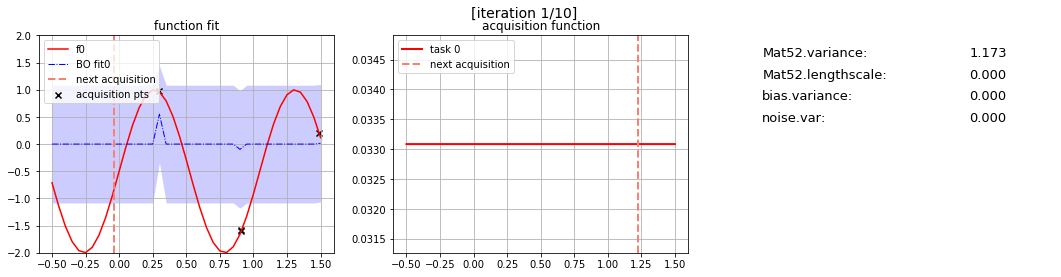

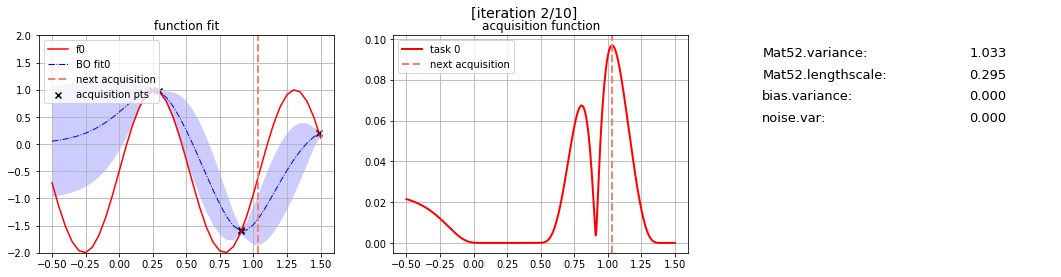

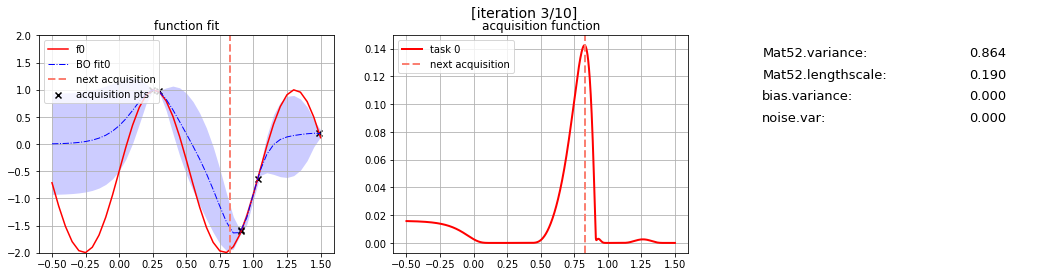

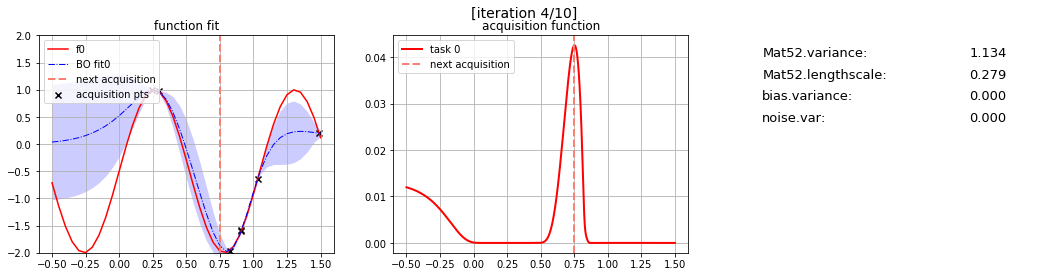

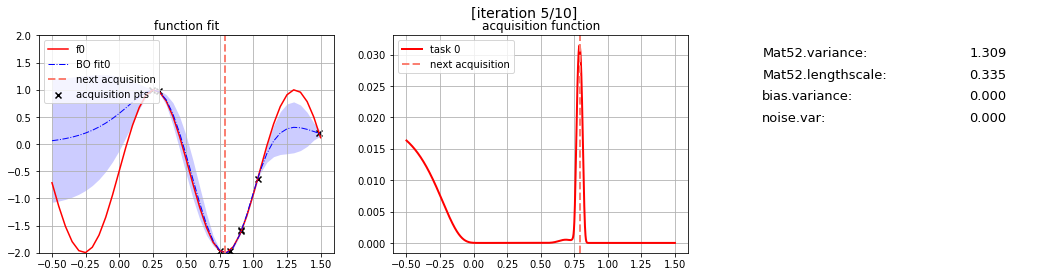

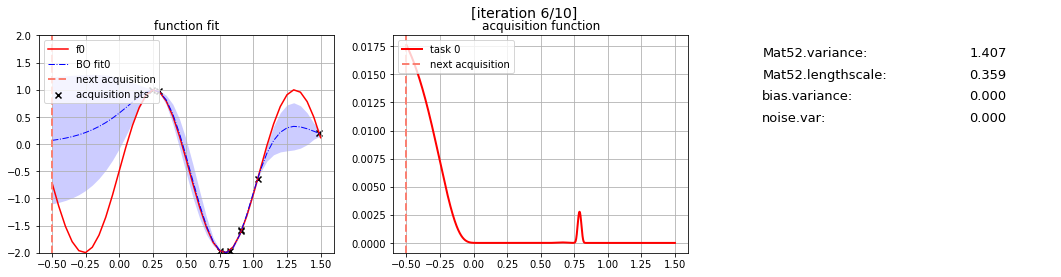

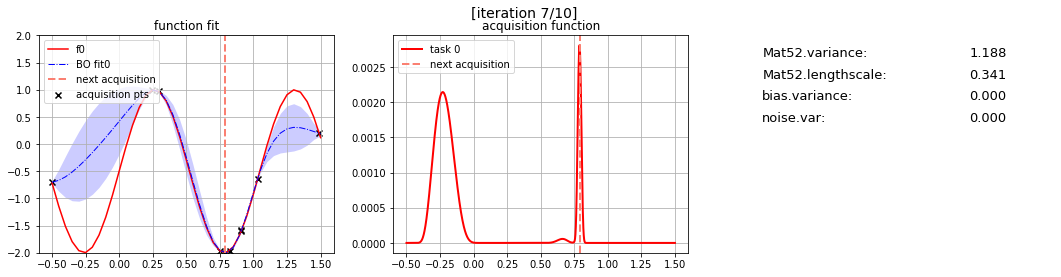

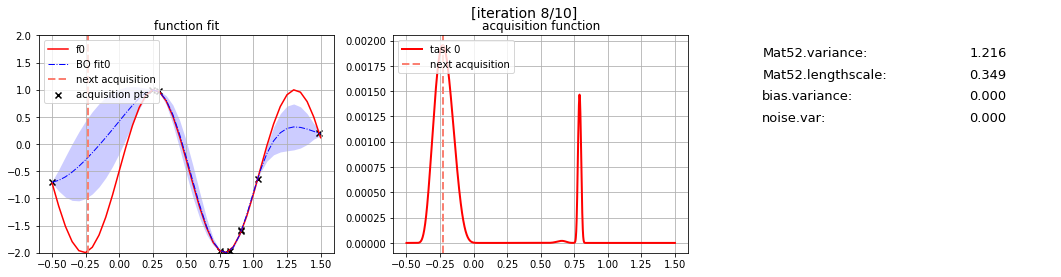

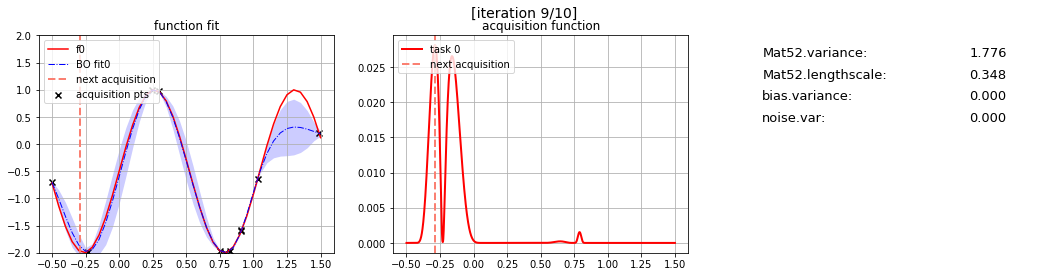

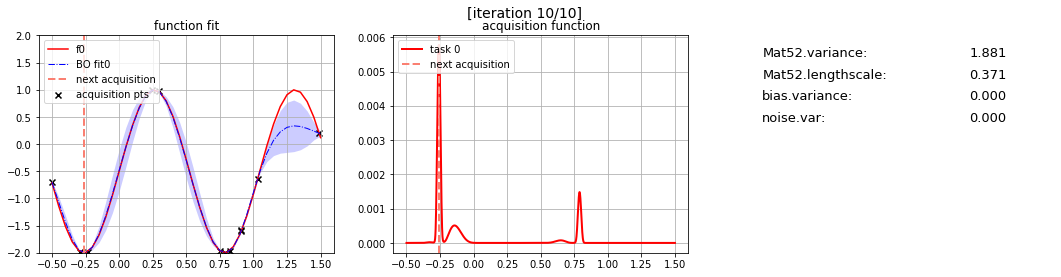

In [30]:
#bo.run_optimization(max_iter = max_iter) 
for i in range(1, max_iter+1):    
    bo.run_optimization(1)    
    
    time.sleep(1.0);  
    plot_bo(bo)    
    plt.gcf().suptitle("[iteration %i/%i]" % (i, max_iter), fontsize=14)    
    display.display(pl.gcf()); 
    display.clear_output(wait=True)    

**'Next acquistion' positions may not match on different plots since each plot queries BO independenly, and for every query independent optimization is performed.**

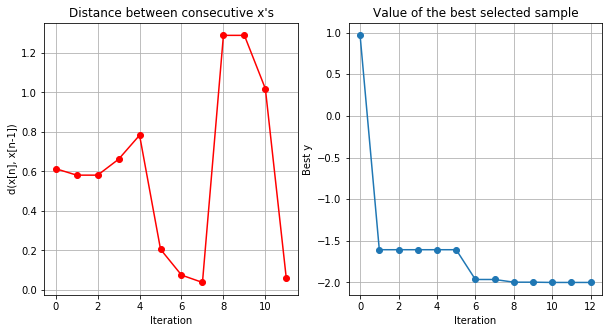

In [31]:
#bo.plot_acquisition()
bo.plot_convergence()

In [32]:
print("x_opt=%s, f(x_opt)=%s" % (bo.x_opt, bo.fx_opt))

x_opt=[0.78862151], f(x_opt)=-1.9995108640220605


## Multi-task regression

**GPyOpt does not handle natively multi-task problems. Instead, conversion of multi-task to one-task needs to be performed by merging tasks and adding one `special' dimension indicating task number.**

In [33]:
# Augment the X data with ones or zeros to indicate the required task number
task0_column = np.zeros((X0.shape[0],1))
task1_column = np.ones((X1.shape[0],1))
X = np.vstack((np.hstack((X0, task0_column)), np.hstack((X1, task1_column))))

# Augment the Y data to indicate accordingly to how tasks were stacked in X
Y = np.vstack([Y0, Y1])

In [34]:
# Coregionalization kernel. The base kernel acts on the first ([0]) data dimension.
# the 'Coregionalize' kernel indexes the outputs, and acts on the second ([1]) `special' data dimension

def get_kernel_mt(input_dim=1, num_outputs=2):
#     kern_corg = GPy.kern.Coregionalize(1, output_dim=2, rank=1)
#     kern_mt = get_kernel_basic()**kern_corg
#     return kern_mt        

    return GPy.util.multioutput.ICM(input_dim, num_outputs, get_kernel_basic(input_dim), W_rank=1, name='ICM')

    #kernels = [GPy.kern.Matern52(input_dim, ARD=1), GPy.kern.Bias(input_dim) ]
    #return GPy.util.multioutput.LCM(input_dim, num_outputs, kernels, W_rank=1, name='LCM')

In [35]:
kern_mt = get_kernel_mt()

In [36]:
print("Hyperparams before learning")
print("(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)")
for k in kern_mt.parameters:
    print("----------")
    print(k)
print("W:\n",kern_mt[".*W.*"])
print("kappa:\n",kern_mt[".*kappa.*"])

Hyperparams before learning
(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)
----------
  sum.               |  value  |  constraints  |  priors
  Mat52.variance     |    1.0  |      +ve      |        
  Mat52.lengthscale  |    1.0  |      +ve      |        
  bias.variance      |    1.0  |      +ve      |        
----------
  B.     |   value  |  constraints  |  priors
  W      |  (2, 1)  |               |        
  kappa  |    (2,)  |      +ve      |        
W:
   index  |      ICM.B.W  |  constraints  |  priors
  [0 0]  |   0.05124812  |               |        
  [1 0]  |   0.24067362  |               |        
kappa:
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        
  [1]    |   0.50000000  |      +ve      |        


In [37]:
# Model definition
model = GPy.models.GPRegression(X, Y, kern_mt)
model.optimize()

In [38]:
print("Hyperparams after learning")
print("(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)")
for k in kern_mt.parameters:
    print("----------")
    print(k)
print("W:\n",kern_mt[".*W.*"])
print("kappa:\n",kern_mt[".*kappa.*"])

Hyperparams after learning
(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)
----------
  sum.               |                value  |  constraints  |  priors
  Mat52.variance     |  0.32681533043545113  |      +ve      |        
  Mat52.lengthscale  |    0.514690880474491  |      +ve      |        
  bias.variance      |   3.3179764165252865  |      +ve      |        
----------
  B.     |   value  |  constraints  |  priors
  W      |  (2, 1)  |               |        
  kappa  |    (2,)  |      +ve      |        
W:
   index  |  GP_regression.ICM.B.W  |  constraints  |  priors
  [0 0]  |             2.71960508  |               |        
  [1 0]  |             1.03305120  |               |        
kappa:
   index  |  GP_regression.ICM.B.kappa  |  constraints  |  priors
  [0]    |                 3.67657822  |      +ve      |        
  [1]    |                 0.07003123  |      +ve      |        


In [39]:
# print("Plotting 95%-Confidence intervals")
# for i in range(2):
#     model.plot(fixed_inputs=[(1, i)],  plot_data=False, plot_inducing=False)
#     plt.plot(X0, Y0, 'x', mew=2, color="salmon")
#     plt.plot(X1, Y1, 'x', mew=2, color="limegreen")    
#     plt.title("task %s" % i)    

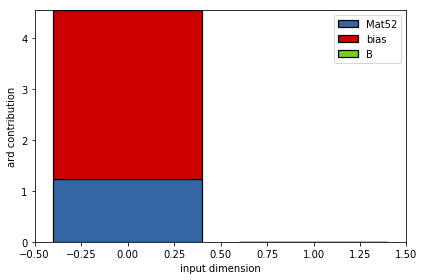

In [40]:
model.kern.plot_ARD(); plt.legend()

## Compare multi-task vs individual fits

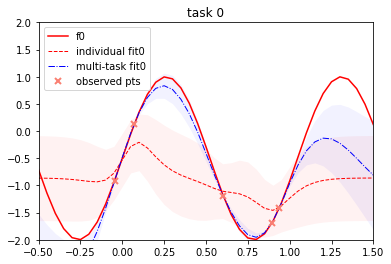

In [41]:
plt.plot(plt_X, f0(plt_X), color="red", label="f0")

plot_err(plt_X, means0, stds0, lw=1, ls="--", color="red", label="individual fit0", alpha_fill=0.05)

task_column =  np.zeros((plt_X.shape[0],1))
xt = np.hstack([plt_X.reshape(-1,1), task_column])
means0mt, var = model.predict(xt)
stds0mt = np.sqrt(var)
plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="multi-task fit0", alpha_fill=0.05)

plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 0");

**Mult-task fit of function no 0 reflects the curvature way better thanks to the information 'transfered' from function no 1**

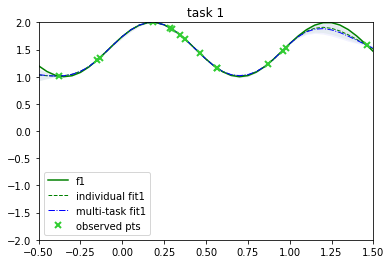

In [42]:
plt.plot(plt_X, f1(plt_X), color="green", label="f1")

plot_err(plt_X, means1, stds1, lw=1, ls="--", color="green", label="individual fit1", alpha_fill=0.05)

task_column =  np.ones((plt_X.shape[0],1))
xt = np.hstack([plt_X.reshape(-1,1), task_column])
means1mt, var = model.predict( xt )
stds1mt = np.sqrt(var)
plot_err(plt_X, means1mt, stds1mt, lw=1, ls="-.", color="blue", label="multi-task fit1", alpha_fill=0.05)

plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 1");

## Multi-task Optimization

### Auxiliary plotting

In [43]:
def plot_next_acquisitions(bo, DIM_NO=0, tasks_to_be_plotted=[0,1]):
    for xt in bo.suggest_next_locations():
        x, t = xt[:-1], int(xt[-1])
        assert t==0 or t==1 # only two tasks allowed for now
        if t not in tasks_to_be_plotted: continue
        plt.axvline(x=x[DIM_NO], color=("salmon" if t==0 else "limegreen"), 
                    ls="--", lw=2, label="next acquisition")

In [44]:
def plot_acquisition(bo, DIM_NO=0, grid=0.001):

    bounds = bo.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[DIM_NO][0], bounds[DIM_NO][1], grid)
    x_grid = x_grid.reshape(len(x_grid),1)

    xt = np.hstack([x_grid, np.zeros((x_grid.shape[0],1))]) # task 0
    acqu0 = -bo.acquisition.acquisition_function(xt)
    plt.plot(x_grid, acqu0, label="task 0", color="red", lw=2)

    xt = np.hstack([x_grid, np.ones((x_grid.shape[0],1))]) # task 1
    acqu1 = -acquisition.acquisition_function(xt)
    plt.plot(x_grid, acqu1, label="task 1", color="green", lw=2)

    #xt = np.hstack([x_grid, np.ones((x_grid.shape[0],1))*0.5]) # task 0.5
    #acqu05 = -acquisition.acquisition_function(xt)
    #plt.plot(x_grid, acqu05, label="task 0.5", color="blue", lw=2)
    
    plot_next_acquisitions(bo, DIM_NO, [0, 1])    
    plt.xlim(-0.6,1.6); plt.legend(loc=2); plt.title("acquisition function"); plt.grid();

In [45]:
def plot_task(bo, TASK_NO): # TODO cover multi-dimensional inputs
    f, color = {0: (f0, "red"), 1: (f1, "green")}[TASK_NO]    
    plt.plot(plt_X, f(plt_X), color=color, label="f0")

    task_column = TASK_NO*np.ones((plt_X.shape[0],1))
    xt = np.hstack([plt_X.reshape(-1,1), task_column])
    means0mt, stds0mt = bo.model.predict(xt)
    plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="BO fit%i" % TASK_NO, alpha_fill=0.05)

    X, Y = bo.get_evaluations()
    if len(X)>0 and X[-1,1]==TASK_NO:
        plt.scatter(X[-1,0],Y[-1,0], color=color, marker="o", s=60, label="prev acquisition")        
    Y, X  = Y[X[:,1]==TASK_NO], X[X[:,1]==TASK_NO,0]
    plt.scatter(X,Y, color="k", marker="x", label="acquisition pts")        

    plot_next_acquisitions(bo, 0, [TASK_NO])    
    plt.xlim(-0.6,1.6); plt.ylim(-2,2); plt.legend(loc=2); plt.title("task %i" % TASK_NO); plt.grid();

In [46]:
def plot_bo(bo):
    plt.figure(figsize=(22,4))
    plt.subplot(1,4,1)
    plot_task(bo, 0); 
    plt.subplot(1,4,2)
    plot_task(bo, 1) 
    plt.subplot(1,4,3)  
    plot_acquisition(bo)
    plt.subplot(1,4,4)  
    plot_params(bo)

### Tasks specification

In [47]:
# MT optimization objective

task_counter = {} # counter of how many times each task was evaluated

def mt_objective(xt):
    assert len(xt)==1 # one sample per batch
    xt = xt[0]     
    assert xt[-1]==0.0 or xt[-1]==1.0 # for now only two tasks supported
    x, t = xt[:-1], int(xt[-1]) # extract coordinates and task number
    task_counter[t] = task_counter.get(t, 0) + 1 # update counts
        
    func = {0: evaluate_f0, 1: evaluate_f1}[t] # use noisy evaluation
    #func = {0: f0, 1: f1}[t] # use exact evaluation
    return func(x)

In [48]:
# Evaluation costs

def cost_const(xt): 
    """constant cost baseline"""
    return np.ones(xt.shape[0])[:,None], np.zeros(xt.shape)


C0 = 10.0 # task 0 evaluation cost
C1 = 1.0 # task 1 evaluation cost

def cost_mt(xt): 
    """different cost for different task no"""   
    t2c = {0: C0, 1: C1} # task to cost
    t2g = {0: [0.0, (C1-C0)], 1: [0.0, (C1-C0)]} # task to gradient # TODO Correct???
    
    costs = np.array([[t2c[int(t)]] for t in xt[:,-1]])        
    gradients = np.array([t2g[int(t)] for t in xt[:,-1]])        
    return costs, gradients 

In [49]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-0.5, 1.5)},
          {'name': 'task', 'type': 'discrete', 'domain': (0, 1)}] #second variable denotes task number

### Model specification

In [50]:
initial_iter = 3
max_iter  = 15                                 
kernel = get_kernel_mt()

#cost = cost_const
cost = cost_mt # with this cost, acquisition function for task 1 is downweighted (flattened)

# def negcost(x):
#     v, g = cost(x)
#     return -v, -g

**Try switching between cost_const and cost_mt**

In [51]:
objective = GPyOpt.core.task.SingleObjective(mt_objective)

model = GPyOpt.models.GPModel(optimize_restarts=5, verbose=False, kernel=kernel, noise_var=None)
space = GPyOpt.Design_space(space=bounds)
acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('random', space, initial_iter)

**Our acquisition heuristic: minimize 2*std/(task_current_max-task_current_min) (cost is included/added when invoking '_compute_acq' from the base class)**

In [52]:
from GPyOpt.acquisitions.base import AcquisitionBase

class MyAcquisition(AcquisitionBase):
    analytical_gradient_prediction = False

    def __init__(self, model, space, optimizer=None, cost_withGradients=None, exploration_weight=2):
        self.optimizer = optimizer
        super(MyAcquisition, self).__init__(model, space, optimizer, cost_withGradients=cost_withGradients)
        self.exploration_weight = exploration_weight
        
    def _compute_acq(self, x): 
        
        def eval_scale(task_no):
          X1 = self.model.model.X
          X1 = X1[X1[:,1]==task_no]
          try:
            mean, var = self.model.model.predict(X1)
            std = np.sqrt(var)
            return (mean.max()-mean.min())+1e-6
          except:
            return 1.0
      
        m, s = self.model.predict(x)   
        f_acqu = self.exploration_weight * s
        
        c0 = eval_scale(task_no=0)
        c1 = eval_scale(task_no=1)
        
        try: f_acqu[x[:,1]==1] = f_acqu[x[:,1]==1]/c1
        except: pass
        try: f_acqu[x[:,1]==0] = f_acqu[x[:,1]==0]/c0
        except: pass
        
        #print(x,"->",f_acqu)        
        return f_acqu

**Choose acquisition function**

In [53]:
# LCB
# acquisition = GPyOpt.acquisitions.AcquisitionLCB(model, space, 
#                                                  optimizer=acquisition_optimizer, 
#                                                  cost_withGradients=cost)

# MPI
# acquisition = GPyOpt.acquisitions.AcquisitionMPI(model, space, 
#                                                  optimizer=acquisition_optimizer, 
#                                                  cost_withGradients=cost)


# EI
# acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, 
#                                                 optimizer=acquisition_optimizer, 
#                                                 cost_withGradients=cost)


# ES (experimental implementation)
# from GPyOpt.util import mcmc_sampler
# ei = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=acquisition_optimizer)
# proposal_function = lambda x : np.clip(np.log(ei._compute_acq(x)), 0., np.PINF)
# sampler = mcmc_sampler.AffineInvariantEnsembleSampler(space)
# acquisition = GPyOpt.acquisitions.AcquisitionEntropySearch(model, space, sampler, 
#                                        optimizer=acquisition_optimizer, 
#                                        num_representer_points=10, 
#                                        burn_in_steps=10, 
#                                        num_samples=100, 
#                                        proposal_function = proposal_function)

# Our heuristic
acquisition = MyAcquisition(model, space, optimizer=acquisition_optimizer, cost_withGradients=cost)

In [54]:
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design, 
                                                normalize_Y=False)

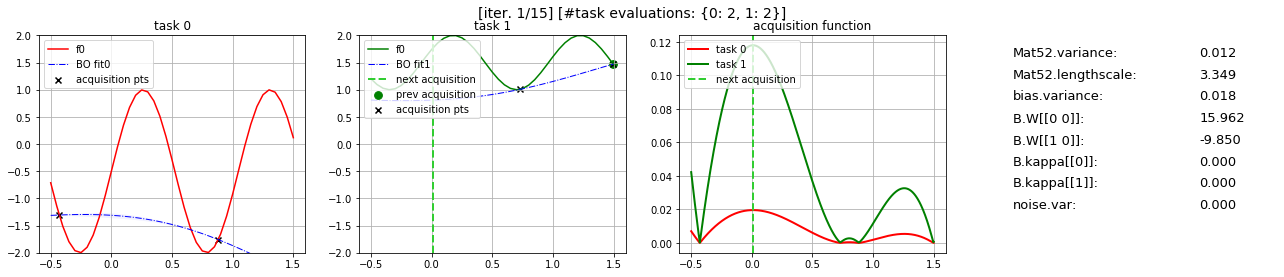

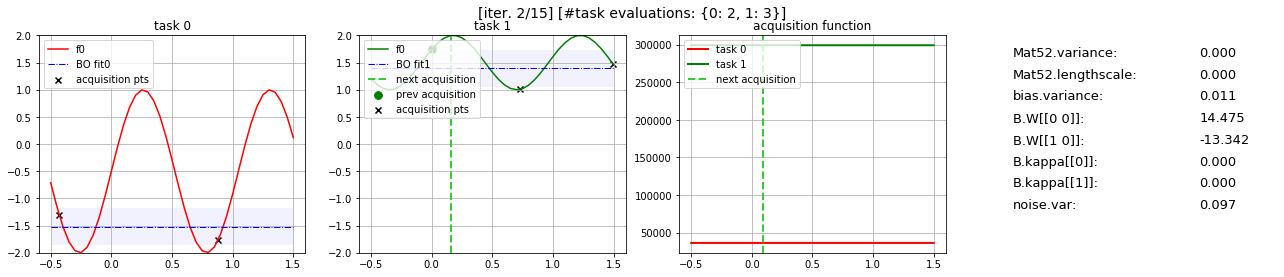

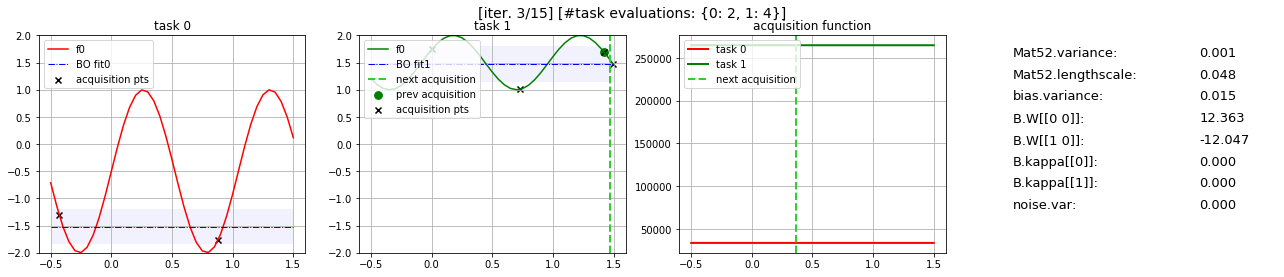

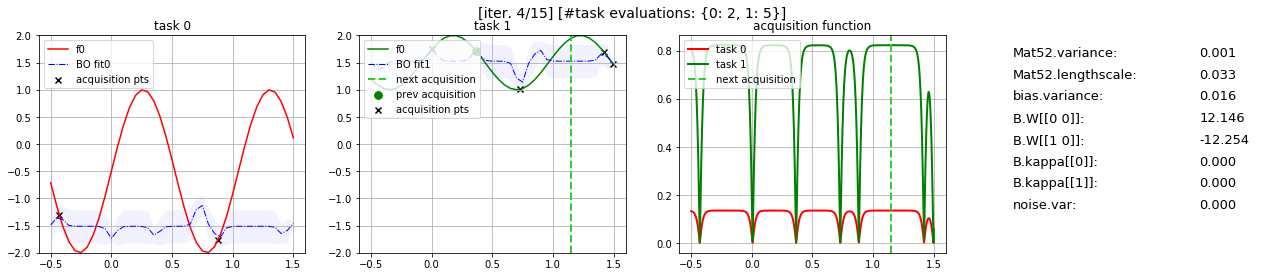

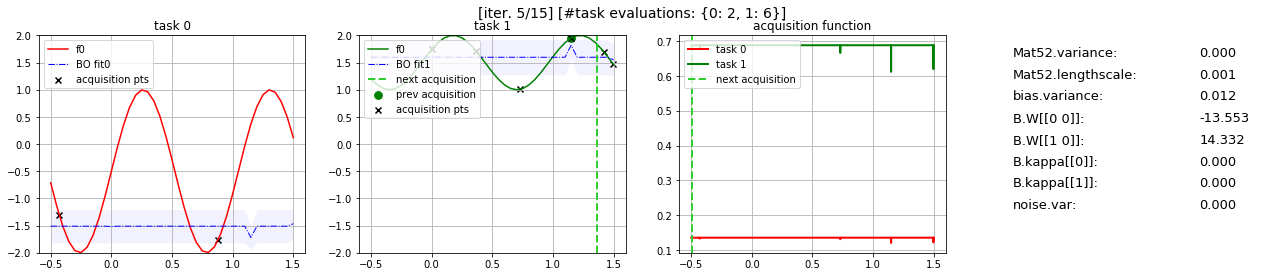

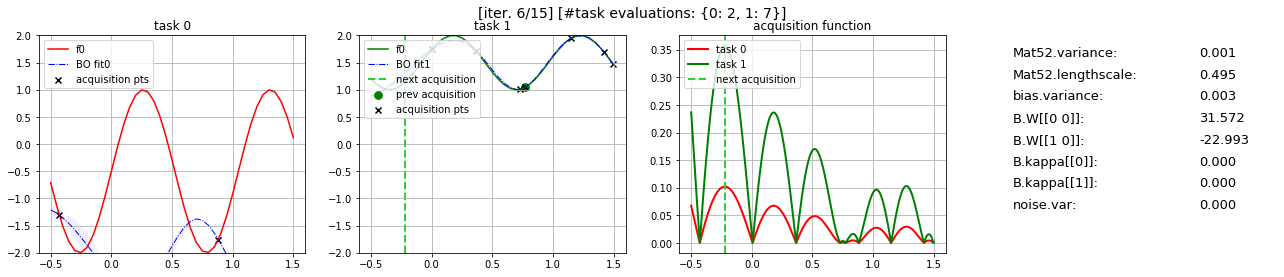

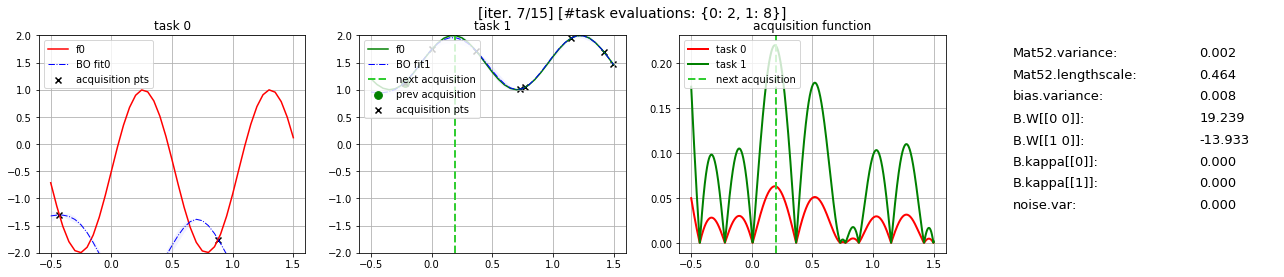

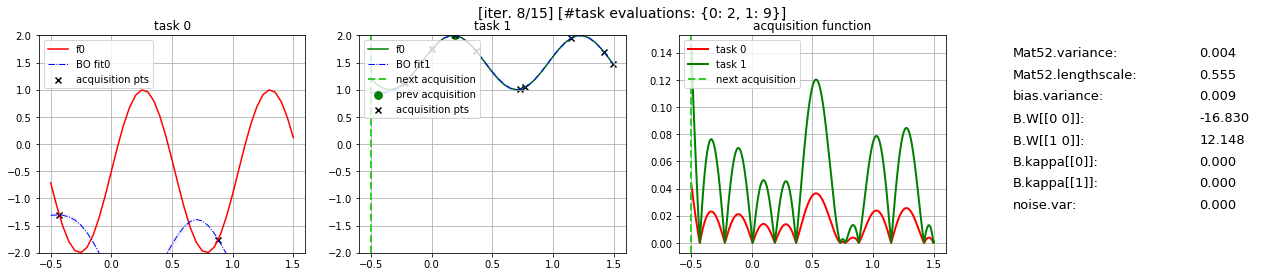

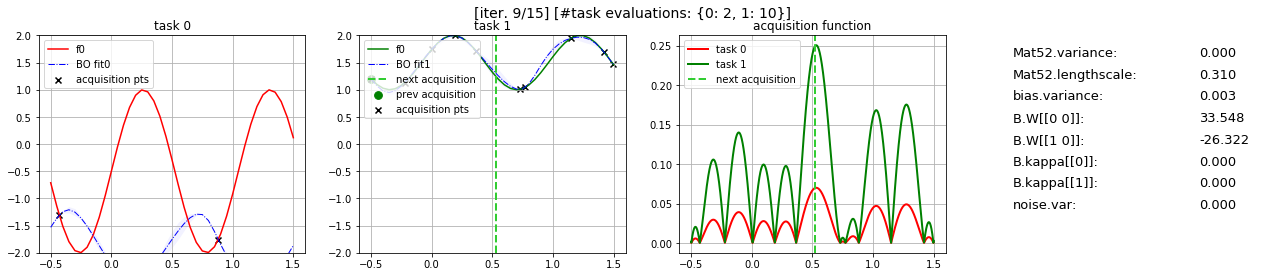

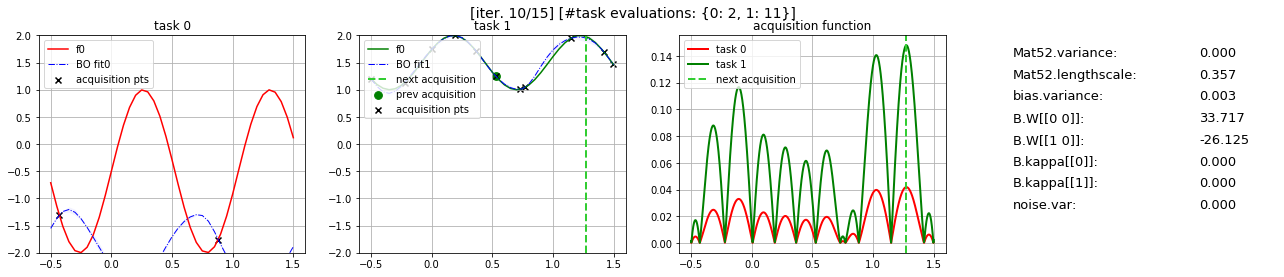

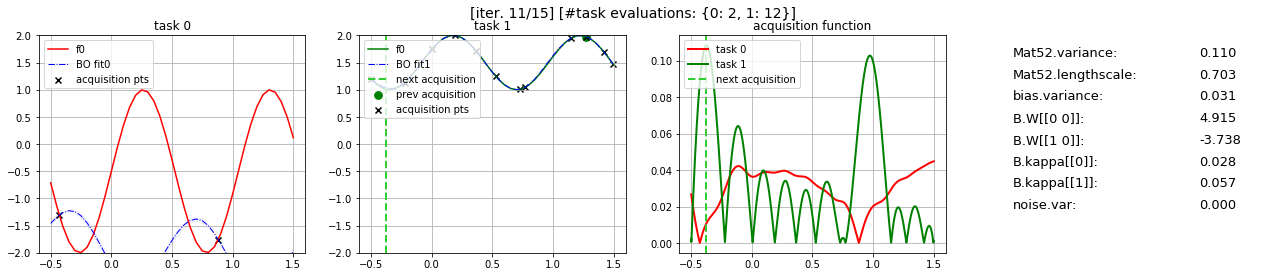

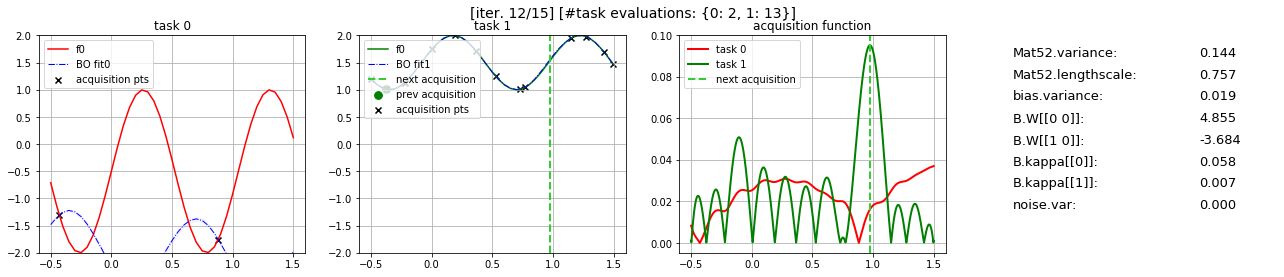

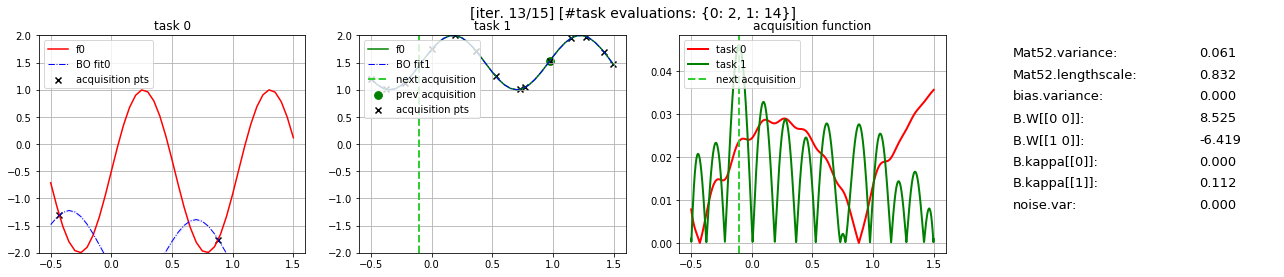

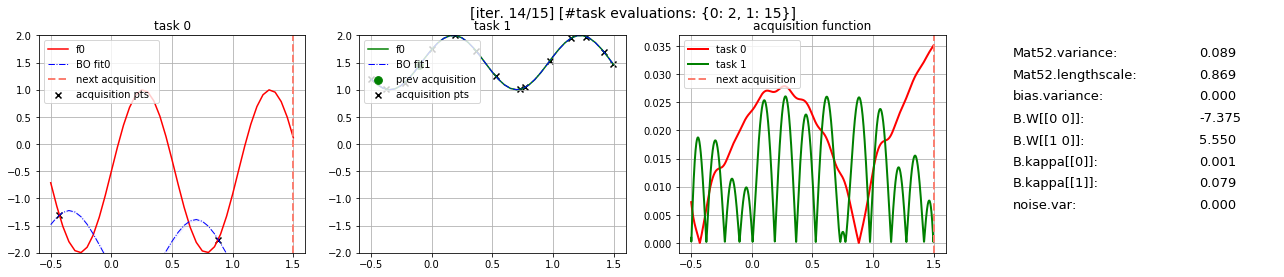

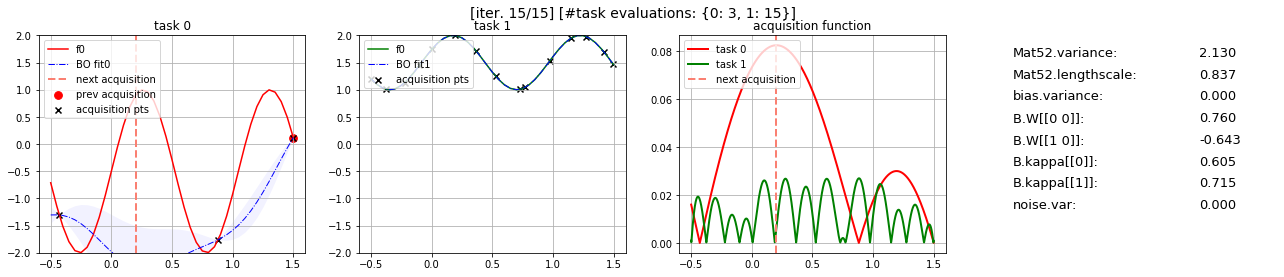

In [55]:
#bo.run_optimization(max_iter = max_iter)
task_counter = {} # reset counter
for i in range(1, max_iter+1):
    bo.run_optimization(1)  
    
    time.sleep(1.0);        
    plot_bo(bo)    
    plt.gcf().suptitle("[iter. %i/%i] [#task evaluations: %s]" % (i, max_iter, task_counter), fontsize=14)            
    display.display(pl.gcf());
    display.clear_output(wait=True);

**'Next acquistion' positions may not match on different plots since each plot queries BO independenly, and for every query independent optimization is performed.**

**TODO: decide where to perform the final evaluation of function 0.**

**TODO: decide when to stop using optimization current status instead of using predefined number of iterations.**

In [56]:
print("x_opt=%s, f(x_opt)=%s, task_counts=%s" % (bo.x_opt, bo.fx_opt, task_counter))

x_opt=[0.8817393 0.       ], f(x_opt)=-1.7577586901950528, task_counts={0: 3, 1: 15}


**GPyOpt doesn't know that we do multi-task; when plotting treats the second dimension in the same way as the first one.**

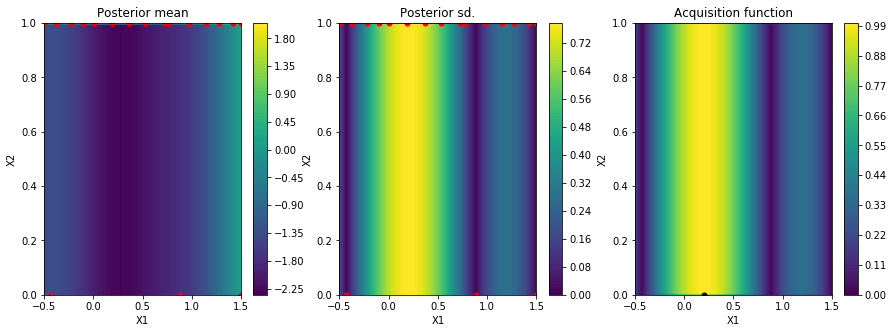

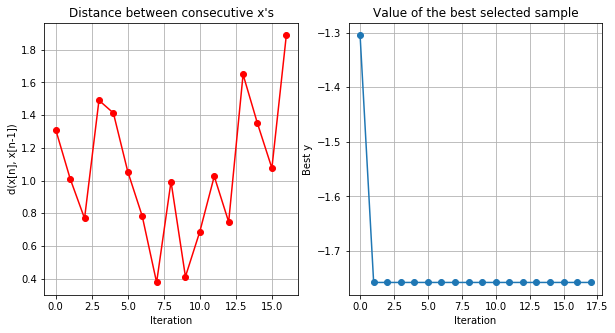

In [57]:
bo.plot_acquisition()
bo.plot_convergence()

## One-line optimization interface (for reference)

**The problem with using the simplified interface is that it does support only several in-built acquisition functions none of which makes sense with problems with different bias and/or scaling.**

In [58]:
task_counter = {}

In [59]:
bo = GPyOpt.methods.BayesianOptimization(mt_objective, 
                                         bounds, 
                                         kernel = get_kernel_mt(), 
                                         acquisition='LCB', 
                                         initial_design_numdata=initial_iter,
                                         cost_withGradients=cost,
                                         normalize_Y=False,
                                         exact_feval=False)

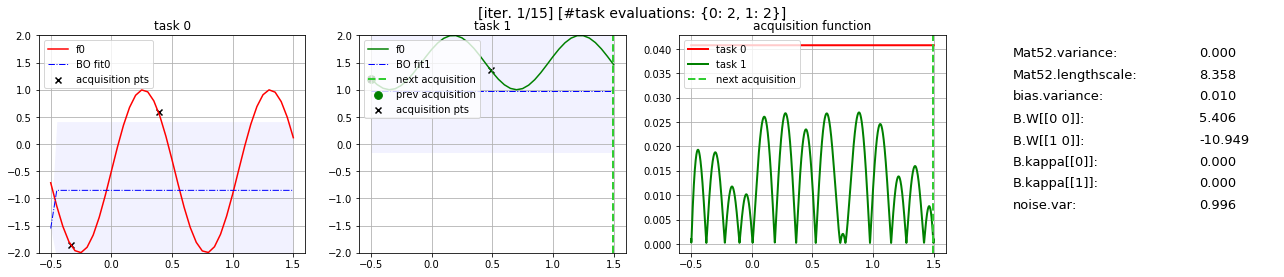

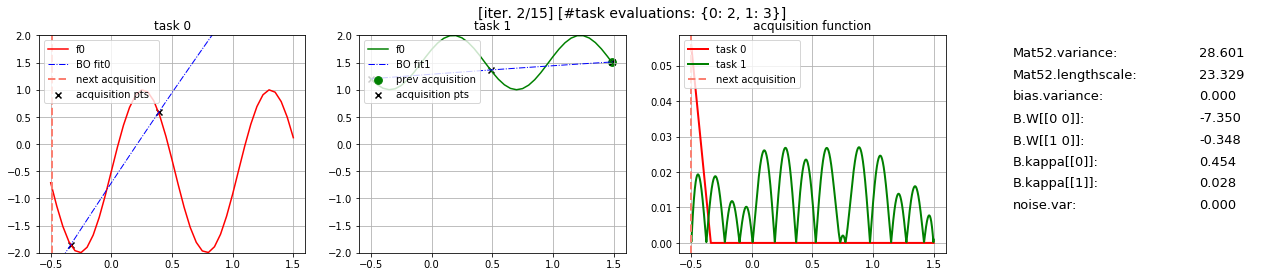

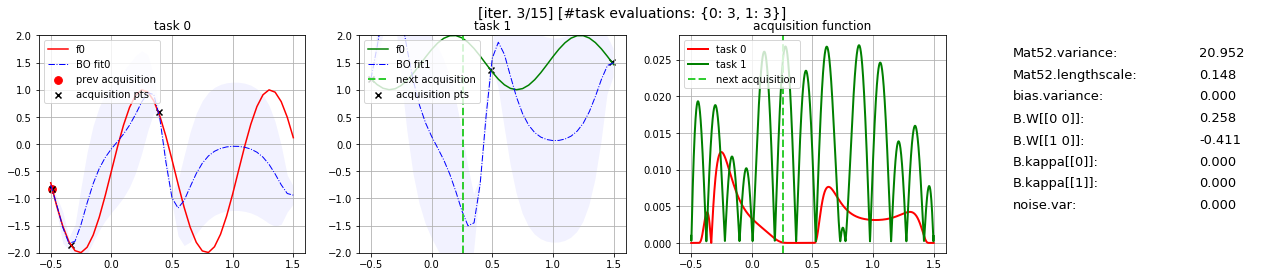

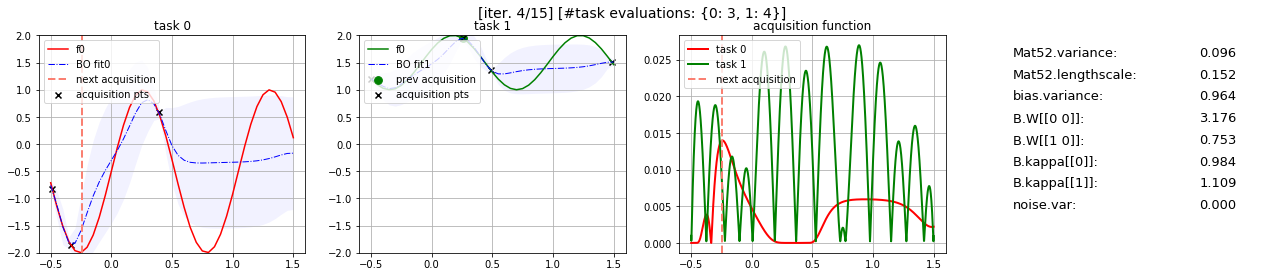

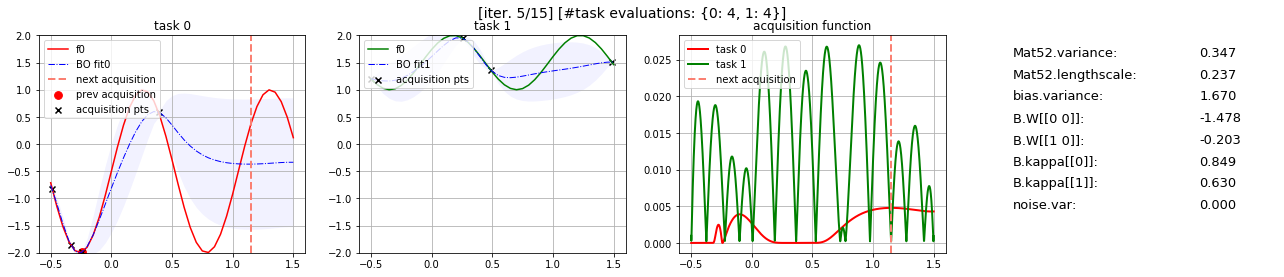

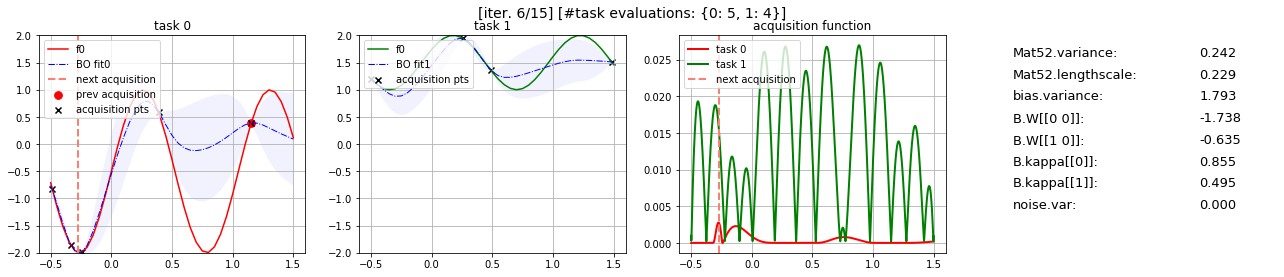

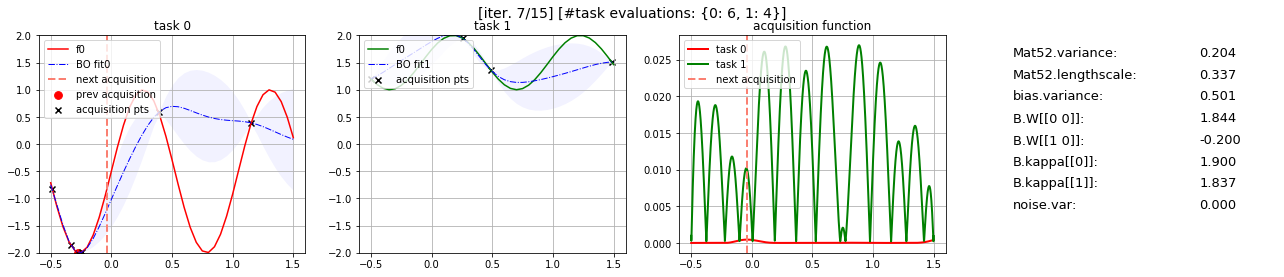

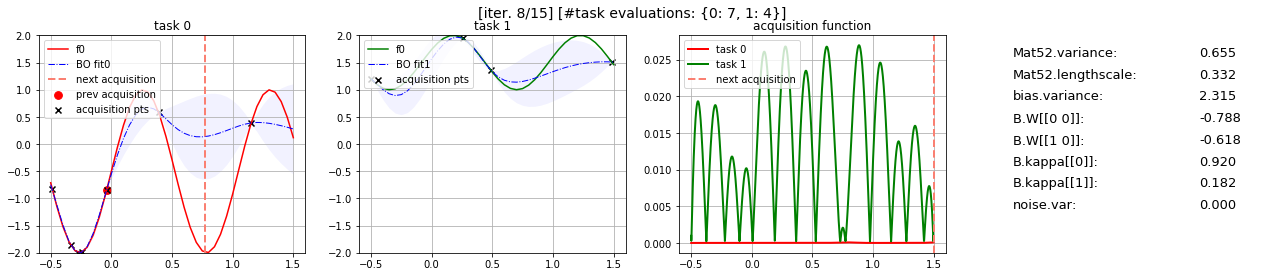

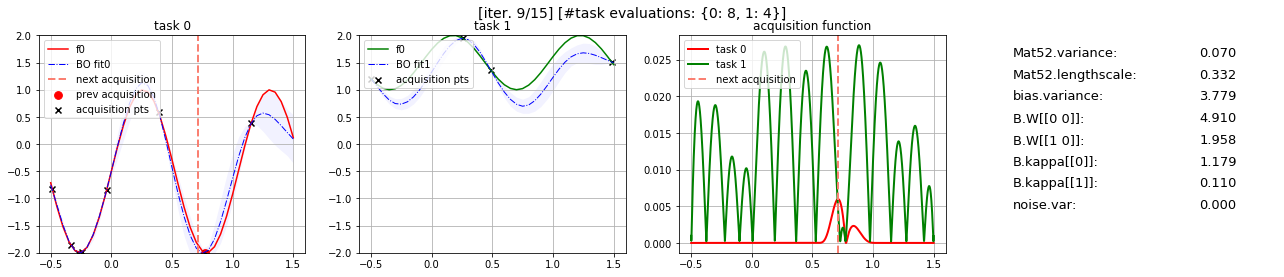

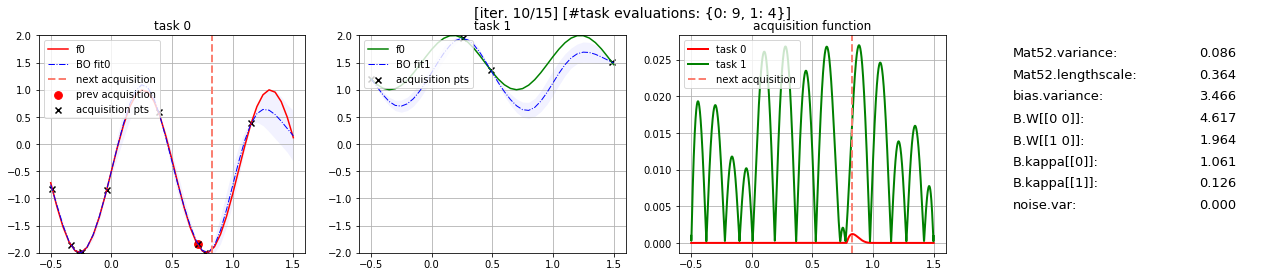

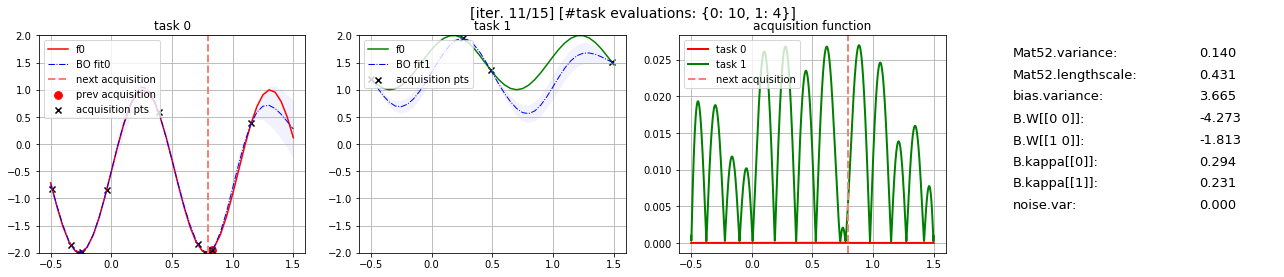

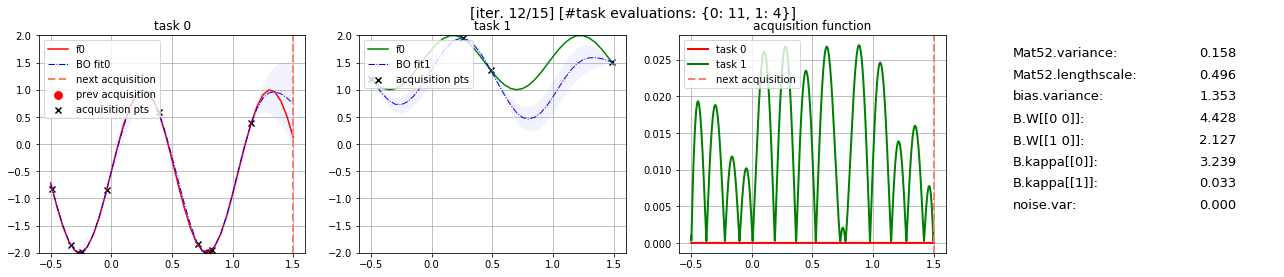

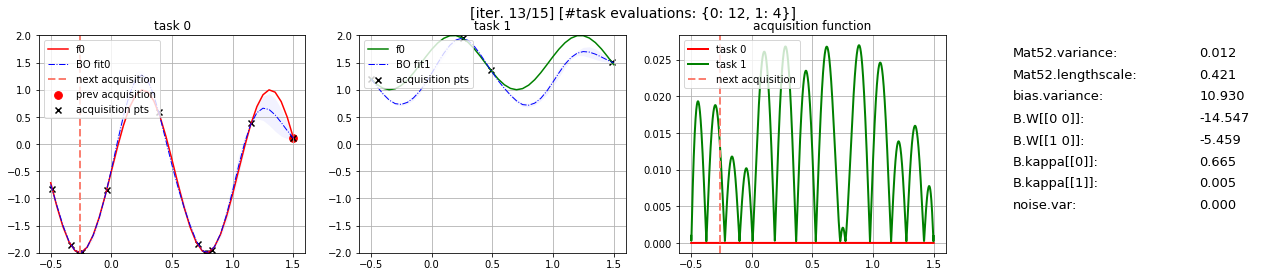

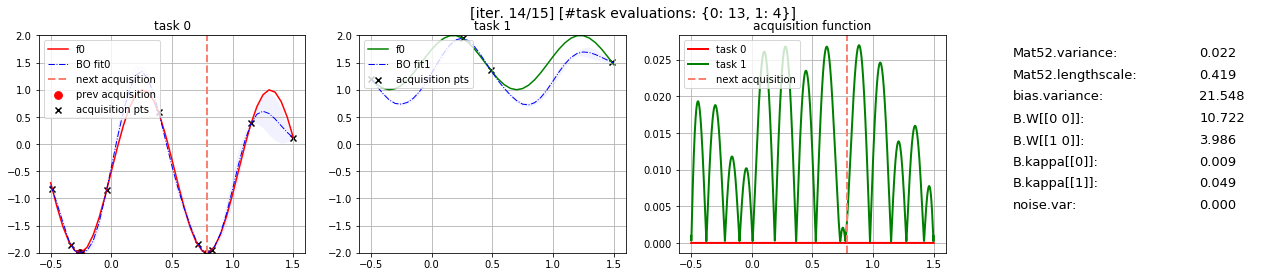

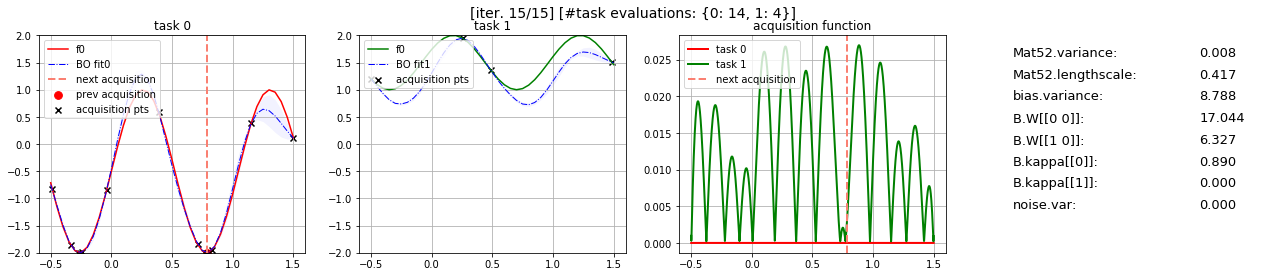

In [60]:
#bo.run_optimization(max_iter = max_iter) 
for i in range(1, max_iter+1):
    bo.run_optimization(1)  
    
    time.sleep(1.0);        
    plot_bo(bo)    
    plt.gcf().suptitle("[iter. %i/%i] [#task evaluations: %s]" % (i, max_iter, task_counter), fontsize=14)            
    display.display(pl.gcf());
    display.clear_output(wait=True);

In [61]:
print("x_opt=%s, f(x_opt)=%s, task_counts=%s" % (bo.x_opt, bo.fx_opt, task_counter))

x_opt=[0.78654795 0.        ], f(x_opt)=-2.002762519808262, task_counts={0: 14, 1: 4}


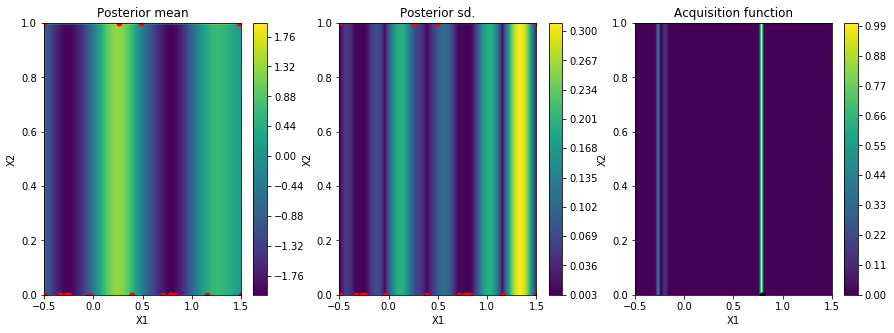

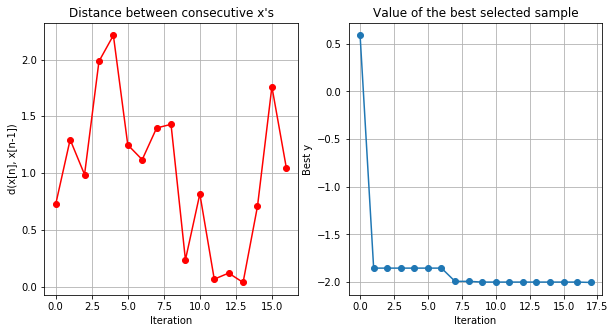

In [62]:
bo.plot_acquisition()
bo.plot_convergence()